# Plot of the likelihood function on SP data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, binom
from scipy.optimize import minimize
from scipy.integrate import cumtrapz
from src.sucess_probability import p_g

# Load the data
grades_data = pd.read_csv('data/grades_hist_pd.csv', sep=';', index_col=0)

for col_name in grades_data.columns:
    grades_data[col_name] = grades_data[col_name] / 100
    
grades_cols = grades_data.columns

n_g_assumption = 3000

for col_name in grades_cols:
    grades_data[str(col_name) + " defaults"] = round(n_g_assumption * grades_data[col_name])

choosen_grades = ["BB", "B"]
default_table = grades_data[[grade + " defaults" for grade in choosen_grades]]
num_of_obligors_table = np.full_like(default_table, n_g_assumption)

In [2]:
from src.MM_estimation import estimate_w_factor_loading
num_of_rows = grades_data.shape[0]
n_g_over_time = np.array([n_g_assumption] * num_of_rows)

MM_params = {}
for grade in choosen_grades:
    MM_params[grade] = estimate_w_factor_loading(grades_data[grade], n_g_over_time, initial_guess=0.45, tolerance=1e-20)
    print(f"Estimated parameters with method of moments for grade {grade}:", MM_params[grade][0], norm.ppf(MM_params[grade][1]))

Estimated parameters with method of moments for grade BB: 0.34959246867789995 -2.3842278912651227
Estimated parameters with method of moments for grade B: 0.3288445137084037 -1.728911139866942


In [3]:
def calculate_likelihood(d_g_arr, n_g_arr, p_g, w_g_arr, gamma_g_arr):
    # Generate a range of values for y from 0 to 1
    y_values = np.linspace(0, 1, num=1000)

    # Calculate the integrand at each value of y
    integrand_values = np.prod(binom.pmf(d_g_arr, n_g_arr, p_g(norm.ppf(y_values), w_g_arr, gamma_g_arr)), axis=1)

    # Integrate the integrand using cumtrapz
    result = cumtrapz(integrand_values, y_values)[-1]

    return result

def log_likehood_multivariable(d_g_array, n_g_array, p_g, w, gamma):
    return sum(np.log(calculate_likelihood(d_g_list, n_g_list, p_g, w, gamma)) for d_g_list, n_g_list in zip(d_g_array, n_g_array))

In [4]:
# Calculate the likelihood for the choosen grades
d_g_array = default_table.to_numpy()
n_g_array = num_of_obligors_table

# 1 w and 2 gamma case

In [5]:
from src.ML_estimation import mle_trapz_g_and_w

optimal_params = mle_trapz_g_and_w(d_g_array, n_g_array, np.array([0.4]), np.array([-2.2, -1.9]))

In [6]:
print("Optimal parameters for w:" , optimal_params[0])
print("Optimal parameters for gamma:" , optimal_params[1])

Optimal parameters for w: [0.33531338]
Optimal parameters for gamma: [-2.37898102 -1.7280394 ]


In [7]:
fixed_gamma2 = optimal_params[1][1]
fixed_gamma2

-1.7280393982502527

# Function of w and gamma_1 with fixed gamma_2

C:\Users\kissp\AppData\Local\Temp\ipykernel_23332\2127192528.py:9: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  result = cumtrapz(integrand_values, y_values)[-1]


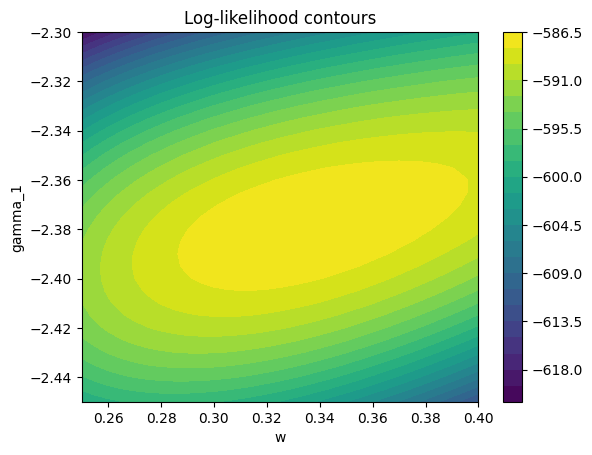

In [8]:
# Contour plot of multivariate plot of the likelihood function
x_num_points = 31
y_num_points = 31

w_g = np.linspace(0.25, 0.4, x_num_points)
gamma_g = np.linspace(-2.3, -2.45, y_num_points)

W, G = np.meshgrid(w_g, gamma_g)
L = np.zeros((y_num_points, x_num_points))

for i in range(x_num_points):
    for j in range(y_num_points):
        L[j, i] = log_likehood_multivariable(d_g_array, n_g_array, p_g, np.array([w_g[i], w_g[i]]), np.array([gamma_g[j], fixed_gamma2]))

plt.contourf(W, G, L, levels=30, cmap='viridis')
plt.colorbar()
plt.xlabel('w')
plt.ylabel('gamma_1')
plt.title('Log-likelihood contours')
plt.savefig('plots/likelihood_contours.pdf')
plt.show()

# Function of gamma_1 and gamma_2 with fixed w

C:\Users\kissp\AppData\Local\Temp\ipykernel_23332\2127192528.py:9: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  result = cumtrapz(integrand_values, y_values)[-1]


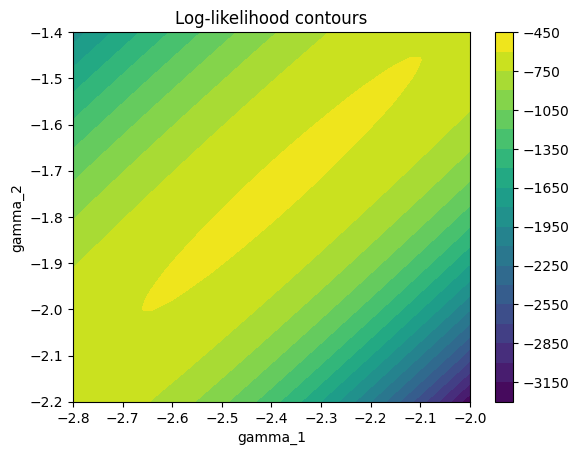

In [9]:
# Contour plot of multivariate plot of the likelihood function with fixed w
x_num_points = 41
y_num_points = 41

w_fixed = optimal_params[0][0]
gamma_1 = np.linspace(-2.8, -2, x_num_points)
gamma_2 = np.linspace(-2.2, -1.4, y_num_points)

G1, G2 = np.meshgrid(gamma_1, gamma_2)
L = np.zeros((y_num_points, x_num_points))

for i in range(x_num_points):
    for j in range(y_num_points):
        L[j, i] = log_likehood_multivariable(d_g_array, n_g_array, p_g, np.array([w_fixed, w_fixed]), np.array([gamma_1[i], gamma_2[j]]))

plt.contourf(G1, G2, L, levels=20, cmap='viridis')
plt.colorbar()
plt.xlabel('gamma_1')
plt.ylabel('gamma_2')
plt.title('Log-likelihood contours')
plt.savefig('plots/likelihood_contours_2.pdf')
plt.show()

# Variable change

In [10]:
from src.variable_change import a_calc_func, b_calc_func, w_calc_func, gamma_calc_func

In [11]:
def calc_linear_likelihood(d_g_arr, n_g_arr, a, b):
    y_values = np.linspace(0, 1, num=1000)

    y_dim = len(y_values)
    a_dim = len(a)

    a_mat = np.tile(a, (y_dim, 1))
    b_mat = np.tile(b, (y_dim, 1))
    y_mat = np.tile(y_values, (a_dim, 1)).T

    integrand_values = np.prod(binom.pmf(d_g_arr, n_g_arr, norm.cdf(a_mat * norm.ppf(y_mat) + b_mat)), axis=1)
    result = cumtrapz(integrand_values, y_values)[-1]
    return result

def log_likehood_variable_changed(d_g_array, n_g_array, a, b):
    return sum(np.log(calc_linear_likelihood(d_g_list, n_g_list, a, b)) for d_g_list, n_g_list in zip(d_g_array, n_g_array))

C:\Users\kissp\AppData\Local\Temp\ipykernel_23332\3299208989.py:12: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  result = cumtrapz(integrand_values, y_values)[-1]


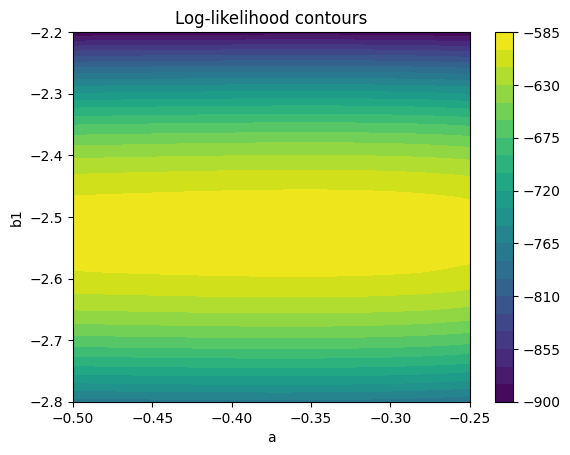

In [12]:
# Contour plot of multivariate plot of the likelihood function with fixed b2
# Function of a and b1
x_num_points = 21
y_num_points = 21

b2_fixed = b_calc_func(optimal_params[0][0], optimal_params[1][1])
a = np.linspace(-0.25, -0.5, x_num_points)
b1 = np.linspace(-2.8, -2.2, y_num_points)

A, B1 = np.meshgrid(a, b1)
L = np.zeros((y_num_points, x_num_points))

for i in range(x_num_points):
    for j in range(y_num_points):
        L[j, i] = log_likehood_variable_changed(d_g_array, n_g_array, np.array([a[i], a[i]]), np.array([b1[j], b2_fixed]))

plt.contourf(A, B1, L, levels=20, cmap='viridis')
plt.colorbar()
plt.xlabel('a')
plt.ylabel('b1')
plt.title('Log-likelihood contours')
plt.savefig('plots/likelihood_contours_3.pdf')
plt.show()

C:\Users\kissp\AppData\Local\Temp\ipykernel_23332\3299208989.py:12: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  result = cumtrapz(integrand_values, y_values)[-1]


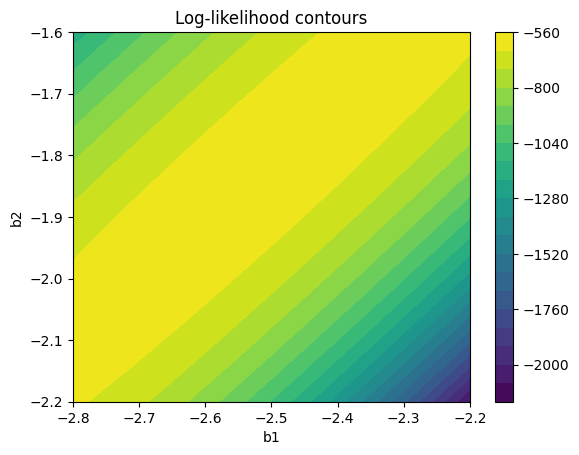

In [13]:
# Contour plot of multivariate plot of the likelihood function with fixed b2
# Function of a and b1
x_num_points = 21
y_num_points = 21

a_fixed = a_calc_func(optimal_params[0], optimal_params[1])[0]
b1 = np.linspace(-2.8, -2.2, y_num_points)
b2 = np.linspace(-2.2, -1.6, y_num_points)

B1, B2 = np.meshgrid(b1, b2)
L = np.zeros((y_num_points, y_num_points))

for i in range(y_num_points):
    for j in range(y_num_points):
        L[j, i] = log_likehood_variable_changed(d_g_array, n_g_array, np.array([a_fixed, a_fixed]), np.array([b1[i], b2[j]]))

plt.contourf(B1, B2, L, levels=20)
plt.colorbar()
plt.xlabel('b1')
plt.ylabel('b2')
plt.title('Log-likelihood contours')
plt.savefig('plots/likelihood_contours_4.pdf')
plt.show()